# Homework 5

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Section 1: Harvard Case

*This section will not be graded, but it will be discussed in class.*

**Smart Beta Exchange-Traded-Funds and Factor Investing**.

* The case is a good introduction to important pricing factors.
* It also gives useful introduction and context to ETFs, passive vs active investing, and so-called “smart beta” funds.

1. Describe how each of the factors (other than MKT) is measured.1That is, each factor is a portfolio of stocks–which stocks are included in the factor portfolio?

2. Is the factor portfolio...
* long-only
* long-short
* value-weighted
* equally-weighted

4. What steps are taken in the factor construction to try to reduce the correlation between the factors?
5. What is the point of figures 1-6?
6. How is a “smart beta” ETF different from a traditional ETF?
7. Is it possible for all investors to have exposure to the “value” factor?
8. How does factor investing differ from traditional diversification?


If you need more info in how these factor portfolios are created, see Ken French’s website, and the follow- details: 

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_mom_factor.html

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.4f}'.format

sys.path.append('../cmds/')

import TA_utils as ta

plt.style.use('ggplot')

from functools import partial
read_excel = partial(pd.read_excel, index_col=0, parse_dates=[0], io='C:/Users/文思琪/Downloads/factor_pricing_data.xlsx')

factors = read_excel(sheet_name='factors (excess returns)')
portfolios = read_excel(sheet_name='portfolios (excess returns)')

***

# 2. The Factors

Use the data found in `factor_pricing_data.xlsx`.

* FACTORS: Monthly excess return data for the overall equity market, $\tilde{r}^{\text{MKT}}$.
* The column header to the market factor is `MKT` rather than `MKT-RF`, but it is indeed already in excess return form.
* The sheet also contains data on five additional factors.
* All factor data is already provided as excess returns

1. Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4.
You now have three additional factors, so let’s compare there univariate statistics. • mean
• volatility
• Sharpe

2. Based on the factor statistics above, answer the following.
(a) Does each factor have a positive risk premium (positive expected excess return)? (b) How have the factors performed since the time of the case, (2015-present)?

3. Report the correlation matrix across the six factors.
* Does the construction method succeed in keeping correlations small?
* Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

4. Report the tangency weights for a portfolio of these 6 factors.
* Which factors seem most important? And Least?
* Are the factors with low mean returns still useful?
* Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

What do you conclude about the importance or unimportance of these styles?

In [95]:
#1.
full_sample = ta.calc_performance_metrics(factors).iloc[:, :3]
full_sample

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
MKT,0.0863,0.1569,0.5499
SMB,0.0083,0.1019,0.0817
HML,0.0258,0.1100,0.2346
RMW,0.0471,0.0832,0.5660
CMA,0.0295,0.0731,0.4041
UMD,0.0627,0.1546,0.4057


,Annualized Return Pre,Annualized Volatility Pre,Annualized Sharpe Ratio Pre,Annualized Return Post,Annualized Volatility Post,Annualized Sharpe Ratio Post
MKT,0.0779,0.1561,0.4992,0.1166,0.1603,0.7274
SMB,0.0160,0.1011,0.1582,-0.0195,0.1045,-0.1866
HML,0.0379,0.1028,0.3685,-0.0179,0.1327,-0.1345
RMW,0.0460,0.0858,0.5366,0.0509,0.0733,0.6939
CMA,0.0400,0.0696,0.5751,-0.0084,0.0840,-0.1001
UMD,0.0742,0.1581,0.4692,0.0211,0.1408,0.1497


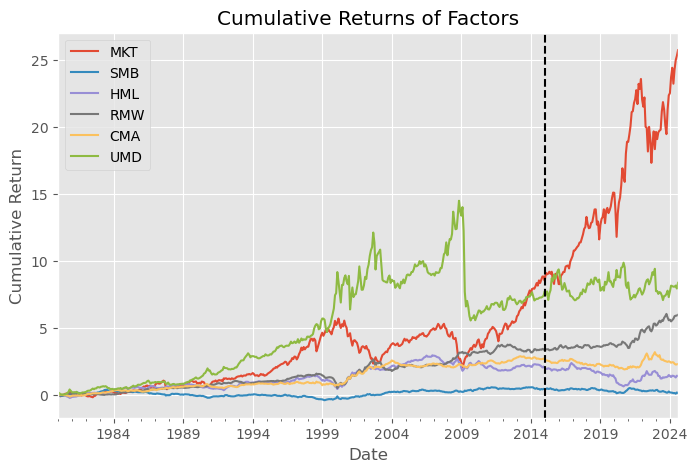

In [97]:
#2(a)according to the result, each factor have a positive risk premium.
#(b)
pre_case = ta.calc_performance_metrics(factors.loc[:'2014']).iloc[:, :3]
post_case = ta.calc_performance_metrics(factors.loc['2015':]).iloc[:, :3]

pre_post = pre_case.join(post_case, lsuffix=' Pre', rsuffix=' Post')
display(pre_post)
# Plot cumulative returns of factors, add vertical line at 2015
fig, ax = plt.subplots(figsize=(8, 5))
cum_rets = (1 + factors).cumprod() - 1
cum_rets.plot(ax=ax)
ax.axvline('2015', color='k', linestyle='--')
ax.set_title('Cumulative Returns of Factors')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date');

MKT has done by far the best, and has been soaring up compared to the other factors, especially after the case. UMD has stayed around flat after the case, although it did well before the case. SMB and HML go from positive expected returns to negative.

Overall, all of the factors except MKT and RMW do worse after the case than before the case.

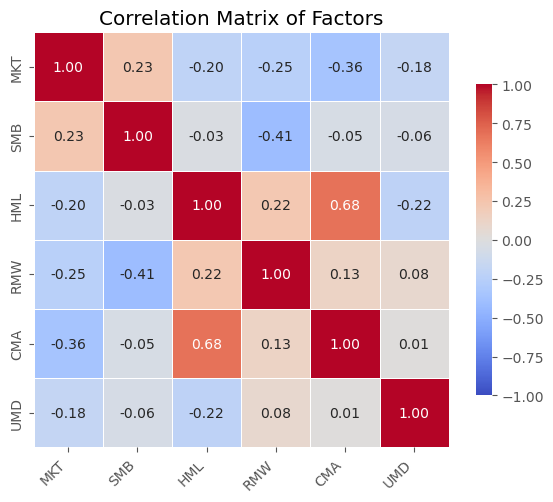

In [100]:
#3
fig, ax = plt.subplots(figsize=(6, 5))
ax = ta.plot_correlation_matrix(factors.corr(), ax=ax)
ax.set_title('Correlation Matrix of Factors')
fig.tight_layout()

1.Does the construction method succeed in keeping correlations small?
I think it does except the correlation between HML and CMA ,which is a little big(0.68).2.
Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case
I would say yes. Given the high correlation HML has to CMA and moderate correlation is has to RMW then it is likely that HML is picking up on something similar to CMA. So, out of all of the factors, it could be the most redundant.?

In [103]:
#4
def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns,columns=['Weight'])

w_tan = tangency_weights(factors)
w_tan.join(full_sample).sort_values('Annualized Return', ascending=False)

,Weight,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
MKT,0.2098,0.0863,0.1569,0.5499
UMD,0.1028,0.0627,0.1546,0.4057
RMW,0.3133,0.0471,0.0832,0.5660
CMA,0.3390,0.0295,0.0731,0.4041
HML,-0.0421,0.0258,0.1100,0.2346
SMB,0.0773,0.0083,0.1019,0.0817


1.Which factors seem most important? And Least?
Acorrding to the weight, CMA seems most important and HML seems least important.2.
Are the factors with low mean returns still useful
b.

Yes, note that CMA and RMW have the highest weights, but definitely do not have the highest mean returns. Both MKT and UMD have better mean returns, but lower weights. This again goes back to the fact that when doing MV-optimization, we are not just looking at mean returns, but also covariances.
?
Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

In [106]:
#3
factors_sub = factors[['MKT', 'SMB', 'HML', 'UMD']]

w_tan_sub = tangency_weights(factors_sub)
w_tan_sub

,Weight
MKT,0.3655
SMB,-0.0324
HML,0.3562
UMD,0.3107


MKT, HML, and UMB all have roughly equal and high weights, and SMB has virtually 0 weight. SO, We could conclude that SMB is probably not super important, and that MKT, HML, and UMB are all important.

***

# 3. Testing Modern LPMs

Consider the following factor models:
* CAPM: MKT
* Fama-French 3F: MKT, SMB, HML
* Fama-French 5F: MKT, SMB, HML, RMW, CMA
* AQR: MKT, HML, RMW, UMD

We are not saying this is “the” AQR model, but it is a good illustration of their most publicized factors: value, momentum, and more recently, profitability.

For instance, for the AQR model is...

![](../refs/LFP-4-factors.png)

We will test these models with the time-series regressions. Namely, for each asset i, estimate the following regression to test the AQR model:

![](../refs/LFD-4-factors.png)

Data
* PORTFOLIOS: Monthly excess return data on 49 equity portfolios sorted by their industry. Denote these as $\tilde{r}^i$ , for $n = 1, . . . , 49.$

* You do NOT need the risk-free rate data. It is provided only for completeness. The other two tabs are already in terms of excess returns.

1. Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)
* For each regression, report the estimated α and r-squared.
* Calculate the mean-absolute-error of the estimated alphas.
* If the pricing model worked, should these alpha estimates be large or small? Why?
* Based on your MAE stat, does this seem to support the pricing model or not?

2. Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model.
   * Report the MAE statistic for each of these models and compare it with the AQR Model MAE.
   * Which model fits best?
   
3. Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

In [118]:
#1
from collections import defaultdict
from itertools import product
import statsmodels.api as sm
#create aqr result dataframe
summary = defaultdict(list)
capm = sm.add_constant(factors['MKT'])
aqr = sm.add_constant(factors[['MKT', 'HML', 'RMW', 'UMD']])
ff3 = sm.add_constant(factors[['MKT', 'SMB', 'HML']])
ff5 = sm.add_constant(factors[['MKT', 'SMB', 'HML', 'RMW', 'CMA']])

col_names = product(['CAPM', 'AQR', 'FF3', 'FF5'], ['Alpha', 'R^2'])
col_names = list(map(lambda x: ' '.join(x), col_names))

summary = pd.DataFrame(0.0, index=portfolios.columns, columns=col_names)

models = [*zip(['CAPM', 'AQR', 'FF3', 'FF5'], [capm, aqr, ff3, ff5])]

for asset in portfolios.columns:
    asset_ret = portfolios[asset]
    for name, X in models:
        model = sm.OLS(asset_ret, X).fit()
        summary.loc[asset, f'{name} Alpha'] = model.params.iloc[0]
        summary.loc[asset, f'{name} R^2'] = model.rsquared
        

summary[['AQR Alpha', 'AQR R^2']]

,AQR Alpha,AQR R^2
Agric,0.0006,0.3392
Food,0.0006,0.4642
Soda,0.0014,0.3084
Beer,0.0014,0.4208
Smoke,0.0029,0.2735
Toys,-0.0031,0.5083
Fun,0.0025,0.6165
Books,-0.0025,0.6868
Hshld,-0.0007,0.5584
Clths,-0.0015,0.6183


In [119]:
#2 use all models
summary.loc[:, summary.columns.str.contains('Alpha')].abs().mean().to_frame('MAE') * 12

,MAE
CAPM Alpha,0.0204
AQR Alpha,0.0230
FF3 Alpha,0.0240
FF5 Alpha,0.0314


#3
I think they should be low because the factors in model can explain nearly all effect on excess return so the constant should be low.
#4
the result should that MAE of alpha are so big.especially in FF5 model. In CAPM model it is lowest but also over 2%.So it didn't support the pricing model.

4. This does not matter for pricing, but report the average (across $n$ estimations) of the time-series regression r-squared statistics.
   * Do this for each of the three models you tested.
   * Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

5. We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.
* Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?4
* Report the MAE of the cross-sectional regression residuals for each of the four models. How do they compare to the MAE of the time-series alphas?

In [124]:
#4.1
summary.loc[:, ~summary.columns.str.contains('Alpha')].mean().to_frame('R^2')

,R^2
CAPM R^2,0.5261
AQR R^2,0.5749
FF3 R^2,0.5715
FF5 R^2,0.5960


***

FF5 model has the highest R square, and CAPM has the lowest R square. but all of them don't have high R square, only explain about 50-60% of the variation.

In [128]:
#5
def calc_pricing_regression(rets, factors, intercept=True, adj=12):
    if intercept:
        factors = sm.add_constant(factors)
    summary = {f'{k} Beta': [] for k in factors.columns[1:]}
    summary['Alpha']  = []
    summary['R^2']    = []
    for asset in rets.columns:
        model = sm.OLS(rets[asset], factors).fit()
        for k, _ in summary.items():
            try:
                summary[k].append(model.params[k[:-5]])
            except:
                pass
        summary['R^2'].append(model.rsquared)
        summary['Alpha'].append(model.params.iloc[0] * adj)
            
    return pd.DataFrame(summary, index=rets.columns)

def calc_cross_sectional_regression(mean_rets, betas, intercept=False):
    if intercept:
        betas = sm.add_constant(betas)
    model = sm.OLS(mean_rets, betas).fit()
    params = model.params.to_frame('Cross Sectional Regression')
    params.loc['R^2'] = model.rsquared
    params.loc['MAE'] = model.resid.abs().mean() 
    return params
frames = []

ts_premia = portfolios.mean() * 12

for name, X in zip(['CAPM', 'AQR', 'FF3', 'FF5'], [capm, aqr, ff3, ff5]):
    pricing_regr = calc_pricing_regression(portfolios, X, intercept=False)
    res = calc_cross_sectional_regression(ts_premia, pricing_regr.iloc[:, :-2], intercept=False)
    res = res.rename({'Cross Sectional Regression': f'{name} CS'}, axis=1)
    frames.append(res)
summary_cs = pd.concat(frames, axis=1).fillna('')
summary_cs_betas.loc[:, 'Time Series'] = factors.mean().values * 12
summary_cs_betas

,CAPM CS,AQR CS,FF3 CS,FF5 CS,Time Series
MKT Beta,0.0861,0.0891,0.1022,0.0965,0.0863
HML Beta,,-0.0387,-0.0152,-0.0310,0.0083
RMW Beta,,0.0437,,0.0336,0.0258
UMD Beta,,0.0607,,,0.0471
SMB Beta,,,-0.0645,-0.0570,0.0295
CMA Beta,,,,-0.0116,0.0627


For MKT, they are alomostly the same. Likewise, for UMD and RMW, there isn't a huge difference. However, for SMB, HML, and CMA, there is a big difference, where a lot of the estimated premia of cross-section are negative but time series are positive.

In [136]:
alpha_mae = summary.loc[:, summary.columns.str.contains('Alpha')].abs().mean().to_frame('MAE') * 12

cs_mae = summary_cs.loc[['MAE']].T

# Append it row-wise
mae = pd.concat([alpha_mae, cs_mae], axis=0)
mae

,MAE
CAPM Alpha,0.0204
AQR Alpha,0.0230
FF3 Alpha,0.0240
FF5 Alpha,0.0314
CAPM CS,0.0204
AQR CS,0.0165
FF3 CS,0.0151
FF5 CS,0.0130


Most of them are smaller than time series regression, with CAPM maintain the same value.